# ScanNet
ScanNet [Dai et al, 2017] has 3D scene dataset with following data.
- Mesh data of scenes
- Sequence RGB and Depth image data, pose matrixes
- camera infomation, semantic segmentation labels, ..., etc.

Related URL
- [ScanNet Homepage](http://www.scan-net.org/index)
- [GitHub](https://github.com/ScanNet/ScanNet)



If you would like to use this tutorial code, Please acquire permission to download ScanNet dataset from the publisher: https://github.com/ScanNet/ScanNet#scannet-data  
After downloading, expand the dataset as follows:

```bash
../../data/ScanNet
├─ task
├─ scans_test
└─ scans
    ├─ <scanId> # ex: scene0000_02
    ：  ├─ <scanId>.sens
        ├─ <scanId>_vh_clean_2.labels.ply
        ├─ <scanId>_vh_clean_2.ply
        └─ sens # You need to create this sens data by https://github.com/ScanNet/ScanNet#data-formats and <scanId>.sens for tutorial
            ├─ color
            ├─ depth
            ├─ intrinsic
            └─ pose
```

For the above files in a `<scanId>` folder, Please refer to [here](https://github.com/ScanNet/ScanNet#data-organization).

In [1]:
%load_ext autoreload
%autoreload 2

This subsection use the following code:

In [2]:
# path to tutlibs
from path import add_dir_path
add_dir_path()

from tutlibs.dataset import ScanNet, ScanNetData
from tutlibs.projection import depth_to_point
from tutlibs.transformation import TransformationMatrix as tm
from tutlibs.visualization import JupyterVisualizer as jv

import cv2
import numpy as np
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
dataset_path = "../../data/ScanNet/scans"
dataset = ScanNet(dataset_path)
data: ScanNetData = dataset[0]

Mesh data is provided for each scene with labels:

In [12]:
vertices, triangle_indices, color_data = data.vh_clean_2_mesh
_, _, label_color_data = data.vh_clean_2_label_mesh

obj_mesh = jv.mesh(vertices, triangle_indices, color_data, color_range=[0, 1])
jv.display([obj_mesh])

obj_mesh_with_label = jv.mesh(vertices, triangle_indices, label_color_data, color_range=[0, 1])
jv.display([obj_mesh_with_label])

Output()

Output()

For each scene, the sequence depth (in `depth` dir) and color data (in `color` dir) is prepared. Also, we can construct a point cloud using a depth image and an intrinsic matrix (in `intrinsic` dir):

frame length: 5578


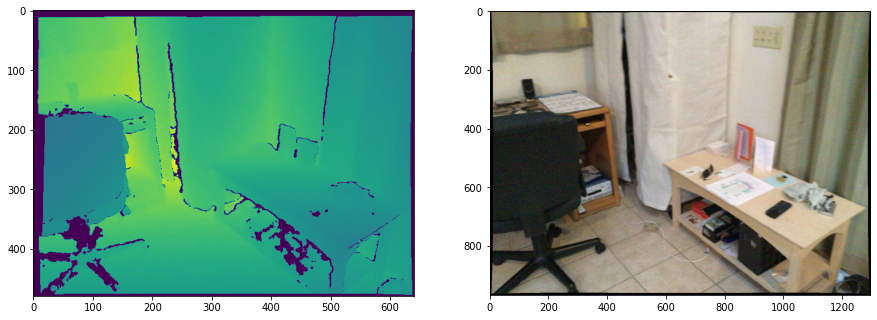

Output()

In [13]:
# check number of frames and select frame index for demonstration.
print(f"frame length: {len(data.color_image_paths)}")
frame_idx = 0

# loading data
depth_image = cv2.imread(data.depth_image_paths[frame_idx], -1)
color_image = cv2.cvtColor(cv2.imread(data.color_image_paths[frame_idx]), cv2.COLOR_BGR2RGB)

# plot images
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(depth_image)
ax2 = fig.add_subplot(222)
ax2.imshow(color_image)
plt.show()


# get a focal length and principal point.
fx = data.depth_image_intrinsic_matrix[0, 0]
fy = data.depth_image_intrinsic_matrix[1, 1]
cx = data.depth_image_intrinsic_matrix[0, 2]
cy = data.depth_image_intrinsic_matrix[1, 2]

# construct a point cloud
point_cloud, pixel_indices = depth_to_point(cv2.imread(data.depth_image_paths[frame_idx], -1), fx, fy, cx, cy)
pose_matrix = np.loadtxt(data.pose_file_paths[frame_idx])
point_cloud = tm.transformation(point_cloud, pose_matrix)
color_image = cv2.resize(color_image, depth_image.T.shape)
colors = color_image[pixel_indices[:,1], pixel_indices[:, 0]]

# plot a point cloud
obj_points = jv.point(point_cloud, colors=colors)
jv.display([obj_points])

We construct a scene point cloud using sequence pose matrixes (in `pose` dir) and depth images.

In [8]:
obj_points_list = []
curr_pose_matrix = np.identity(4, np.float32)

for frame_idx in range(0, len(data.pose_file_paths), 300):
    # loading data
    pose_matrix = np.loadtxt(data.pose_file_paths[frame_idx])
    depth_image = cv2.imread(data.depth_image_paths[frame_idx], -1)
    color_image = cv2.cvtColor(cv2.imread(data.color_image_paths[frame_idx]), cv2.COLOR_BGR2RGB)

    # construct a point cloud from a depth image
    point_cloud, pixel_indices = depth_to_point(depth_image, fx, fy, cx, cy)
    point_cloud /= 1000 # scaling
    trans_point_cloud = tm.transformation(point_cloud, pose_matrix)
    
    # get point colors
    color_image = cv2.resize(color_image, depth_image.T.shape)
    colors = color_image[pixel_indices[:,1], pixel_indices[:, 0]]

    obj_points_list.append(jv.point(trans_point_cloud, colors=colors))

jv.display(obj_points_list)

Output()

## Reference
- [Dai, Angela, Angel X. Chang, Manolis Savva, Maciej Halber, Thomas Funkhouser, and Matthias Nießner. 2017. “Scannet: Richly-Annotated 3d Reconstructions of Indoor Scenes.” In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 5828–39.](https://arxiv.org/abs/1702.04405)